### Char-level Language Modeling - Part 1
In this tutorial, we will be building char-level bi-gram language models:
* Bi-gram count based language model
* Bi-gram neural network based language model
* N-gram MLP based lanugae model, insipred by [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

This tutorial is a summary of my learnings from Andrej Karpathy's [makemore lecture](https://www.youtube.com/watch?v=PaCmpygFfXo) <!-- and Chip Huyen's [ML system design](https://huyenchip.com/machine-learning-systems-design/design-a-machine-learning-system.html#design-a-machine-learning-system-dwGQI5R). -->

Designing a machine learning system is a multi-step iterrative process:
1. Defining the problem
2. Data collection and pre-processing
3. Modelling and Training
4. Evaluation of the model
5. Deployment of the model

Without further ado, let's build our first language model. 

In [126]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

### Bi-gram count based lanugae model

#### 1. Defining the problem
We want to build a machine learning system which can generate new plausible English names for a person. 


#### 2. Data collection
To train a machine learning system we need example dataset. In our case, we will need a dataset of English names.\
We will be using the same [names.txt](https://github.com/karpathy/makemore/blob/master/names.txt) used in Andrej Karpathy's makemore lecture series.

Let's explore the dataset.

In [127]:
# read names.txt file
names = None
with open("names.txt",'r') as file:
    names = file.read().splitlines() #splitline will split the text on '\n' character and will return a list of strings

In [128]:
n_names = len(names)
print(f"Total no. of names in the dataset: {n_names}")
print(f"List first few names: {names[:10]}")
lengths = [len(w) for w in names]
print(f"Length of longest word: {max(lengths)} ({names[lengths.index(max(lengths))]}) and shortest word: {min(lengths)} ({names[lengths.index(min(lengths))]})")

Total no. of names in the dataset: 32033
List first few names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Length of longest word: 15 (muhammadibrahim) and shortest word: 2 (an)


Since our goal is to generate new words, we need to tell the model about start and end of a word. To represent the start of a word, \<S> or \<Start> token is used and similarly, to represnt the end of a word \<E> or \<End> token is used. We will be using the same token "**.**" for start and end token.

Create character vocabulary:

In [129]:
# let's create a character vocabulary for names dataset and also add ".", the start token to the vocab
char_vocab = ['.'] + sorted(set("".join(names)))
vocab_size = len(char_vocab)
print(f"{vocab_size=} and characters in vocab: {''.join(char_vocab)}")

# character to index mapping
chartoi = {}
# index to character mapping
itochar = {}
for i, c in enumerate(char_vocab):
    chartoi[c] = i
    itochar[i] = c
print(f"{chartoi=}")
print(f"{itochar=}")

vocab_size=27 and characters in vocab: .abcdefghijklmnopqrstuvwxyz
chartoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itochar={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


Compute all the bi-grams for the names dataset

To compute bi-gram, add "**.**" in the beginning and in the end of each word.

* A bigram is a list of all possible substrings of length 2
* An N-gram is a list of all possible substrings of length N

In [130]:
# bigram:count dictionary of bigrams
bigrams = {}
total_bigrams = 0
for i, name in enumerate(names):
    # string to list of characters in the given string
    chars = ['.'] + list(name)+ ['.']
    # cool way to generate bigrams of a word in python
    for char1, char2 in zip(chars[:-1], chars[1:]):
        bigrams[(char1,char2)] = bigrams.get((char1,char2), 0) + 1
        total_bigrams += 1
    if i == 0:
        print(f"First word: {name}\n{chars=}\n{bigrams=}")
print(f"Number of unique bigrams: {len(bigrams)}")
print(f"Total number of bigrams in the dataset: {total_bigrams}")

First word: emma
chars=['.', 'e', 'm', 'm', 'a', '.']
bigrams={('.', 'e'): 1, ('e', 'm'): 1, ('m', 'm'): 1, ('m', 'a'): 1, ('a', '.'): 1}
Number of unique bigrams: 627
Total number of bigrams in the dataset: 228146


If the vocabulary has 27 characters, then the number of possible bigrams is 27*27 = 729

In [131]:
# sort the bigrams wrt count in descending order
bigrams = sorted(bigrams.items(), key=lambda x:x[1], reverse=True)
# bigrams

What does the bigram count dictionary tell?\
(x,y): 9 means how many times x followed by y occurred in the dataset

Let's create a count table or matrix for better visualization and understanding of bigram counts
* vertical axis: first character of bigram (total no. of possible characters is vocab_size)
* horizontal axis: second character of bigram (total no. of possible characters is vocab_size)

count_table[x,y] = how many time x (previous character) was followed by y (next character) i.e the occurrence of bigram "xy"

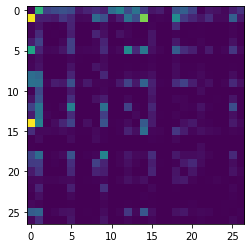

In [132]:
count_table = torch.zeros((vocab_size, vocab_size)) # default dtype=torch.float32

for bigram, count in bigrams:
    ch1, ch2 = bigram
    count_table[chartoi[ch1], chartoi[ch2]] = count
    
plt.imshow(count_table)

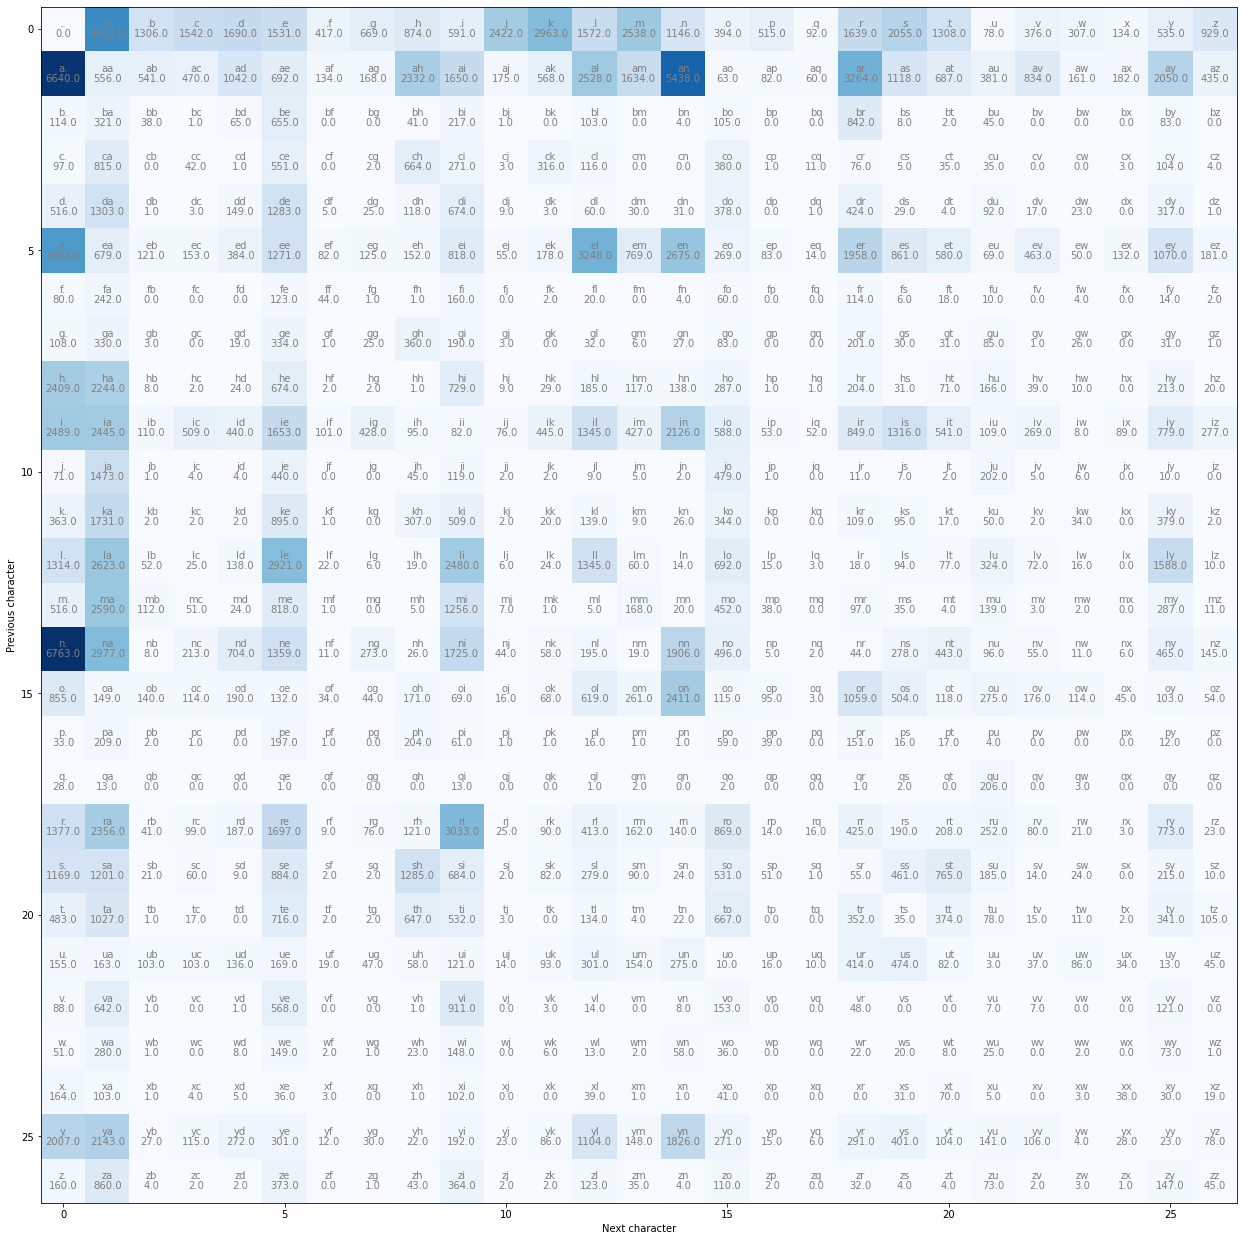

In [133]:
# this code block is from Andrej's lecture
plt.figure(figsize=(22,22))
plt.imshow(count_table, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itochar[i] + itochar[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, count_table[i, j].item(), ha="center", va="top", color='gray')
plt.xlabel("Next character")
plt.ylabel("Previous character")
plt.axis();

#### 4.Modeling
Given current character, predict what would be the next character.\
**Baseline:** \
A simple baseline model would be: given a character, if all characters have equal probability (1/27=0.037) of occuring as the next character.\
**Proposed model:** \
Learn the probability distribution over all the characters (entire vocabulary) given a character. There are two ways to use this probability distribution to predict the next character given a character:
* Predict the character with maximum probablity, but this would generate only one word for a fixed starting character.
* Sampling from the probability distribution will solve the above problem; now, for a fixed starting character, we can generate many different words because every time, a different character will be sampled from the distribution (with replacement).

How can use the count_table to get these probabilities?\
As we know,\
`count_table[x,y]` = how many time `x` (previous character) was followed by `y` (next character)\
\
row corresponding to character *x* (`count_table[x,:`]):\
If `count_table[x,:]` is normalized by sum of all the counts in that row, then\
`count_table[x,y]` = probability of `x` (previous character) followed by `y` (next character)

So, row `count_table[x,:]` gives a probability distribution over all the characters as the next character given character *`x`*

**Training: Computing the probability table**

In [134]:
probs = count_table / count_table.sum(dim=-1, keepdim=True) # -1 is the last dimension
# check if above tensor operation gives desired results
assert (probs[11] == count_table[11]/count_table[11].sum()).all()
# check if each row sums to 1.0
assert (probs.sum(dim=-1).round() == torch.ones(vocab_size)).all()

#### Generation:
This probability table can be used to generate new plausible English names.\
Row `count_table[x,:]`: Probability distribution over all the characters as the next character given character *x* is a *categorical* distribution (aka *multinoulli* distribution, a special case of the **multinomial** distribution) over `vocab_size`(27) categories (character).\
Generating new plausible English names using the above `probs` table

In [135]:
# for reproduciblity of results
g = torch.Generator().manual_seed(2147483647)
n = 10 # generate n words
for i in range(10):
    # start token
    curr_char = '.'
    curr_word = ''
    while True:
        # sample index of next character
        next_char_ix = torch.multinomial(probs[chartoi[curr_char]], num_samples=1, replacement=True, generator=g).item()
        curr_char = itochar[next_char_ix]
        curr_word += curr_char
        if curr_char == '.':
            print(curr_word)
            break

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


Let's also generate words using our baseline model i.e uniform probability (=1/27) distribution over all the characters\
We can `torch.randint` which gives random integers generated uniformly between low(=0) (inclusive) and high(=27)(exclusive).


In [136]:
# for reproduciblity of results
g = torch.Generator().manual_seed(2147483647)
n = 10 # generate n words
for i in range(10):
    # start token
    curr_char = '.'
    curr_word = ''
    while True:
        # sample index of next character
        next_char_ix = torch.randint(low=0, high=27, size=(1,), generator=g).item()
        curr_char = itochar[next_char_ix]
        curr_word += curr_char
        if curr_char == '.':
            print(curr_word)
            break

.
zpleihsxgtvqpsgip.
czwftvgdanmehww.
nfvaejgjkqpwxumidzawywrtwzwegb.
vexfknlwlnrokczeikudwfwpnilovamwlshqn.
ilvxxlrindhq.
janfhbprmbrxsbwhghiileshtfuuosdilzmzftrskqbwt.
vpsjbgtmsiibxtmvi.
iwcoov.
nchtesrqfenu.


By looking at the generated words, we can say that our count-based bigram language model is able to generate more plausible names than a uniform baseline model.

#### How can we do a qunatitative evaluation of these models?
We can use **Maximum Likelihood Estimate (MLE)** method to evaluate a model's performance. The goal of MLE is to maximize the likelihood (probability) of the data (D) w.r.t. model parameters (occurrence info learned from data)\
**Maximizing** the likelihood is equivalent to:
* maximizing the log likelihood (because log is a monotonic function)
* **minimizing** the **negative** log likelihood
* minimizing the average negative log likelihood over the entire dataset

In general, minimizing the average negative log likelihood over the entire dataset is used to evaluate a model's performance.

$\mathrm{P}(D) = \mathrm{P}({W}_{1},{W}_{2},{W}_{3},...,{W}_{N})$\
Since all the words occurr independently,\
$\mathrm{P}(D) =\prod_{i = 1}^{N} P({W}_{i})$ here, D is the entire English names dataset\
${W}_{i} = ({c}_{1}{c}_{2}{c}_{3}....{c}_{m})$ each word is a sequence of characters\
Using the chain rule,\
$P({W}_{i}) = P({c}_{1})P({c}_{2}\mid{c}_{1})P({c}_{3}\mid{c}_{1},{c}_{2})....P({c}_{m}\mid{c}_{1},{c}_{2}....{c}_{m-1})$\
Using Markov assumption, we approximate	each component in the product
* *Unigram* Language model (LM): each character occurrs independently of any other character\
$P({W}_{i}) = P({c}_{1})P({c}_{2})P({c}_{3})....P({c}_{m})$ 
* *Bi-gram* LM: every character is conditioned on previous character\
$P({W}_{i}) = P({c}_{1})P({c}_{2}\mid{c}_{1})P({c}_{3}\mid{c}_{2})....P({c}_{m}\mid{c}_{m-1})$ 
* *N-gram* LM: every character is conditioned on *N-1* previous characters\
$P({W}_{i}) = P({c}_{1})P({c}_{2}\mid{c}_{1})P({c}_{3}\mid{c}_{2},{c}_{1})....P({c}_{m}\mid{c}_{m-N+1},{c}_{m-N+2},...{c}_{m-1})$\
these *N-1* characters are called *context*\
For unigram LM, no context\
For bigram LM, context of one character (previous character)\

For our bigram LM model, Likelihood Estimate:\
$\mathrm{P}(D) =\prod_{i = 1}^{N} P({c}_{i,1})P({c}_{i,2}\mid{c}_{i,1})P({c}_{i,3}\mid{c}_{i,2})....P({c}_{i,m}\mid{c}_{i,m-1})$\
Log likelihood, $\log(\mathrm{P}(D)) = \sum_{i = 1}^{N} \sum_{j = 1}^{m} \log(P({c}_{i,j}\mid{c}_{i,j-1}))$\
${\sf Average Log Likelihood} = \frac{1}{N}\sum_{i = 1}^{N} \sum_{j = 1}^{m} \log(P({c}_{i,j}\mid{c}_{i,j-1}))$\
${\sf Average Neg Log Likelihood (NLL)} = -\frac{1}{N}\sum_{i = 1}^{N} \sum_{j = 1}^{m} \log(P({c}_{i,j}\mid{c}_{i,j-1}))$

In short, log likelihood is the sum of log probabilities of all the bi-grams present in the training data.

Let's compute negative log likelihood (NLL) for our model. We will compute NLL in two ways:

In [137]:
log_likelihood = 0
total_bigrams = 0
for bigram, count in bigrams:
    ch1, ch2 = bigram
    log_likelihood += count * torch.log(probs[chartoi[ch1], chartoi[ch2]]).item()
    total_bigrams += count
print(f"{log_likelihood=}")
log_likelihood /= total_bigrams
nll = -log_likelihood
print(f"{nll=}")


log_likelihood=-559873.5915061831
nll=2.454014497322693


In [138]:
log_likelihood = 0.0
total_bigrams = 0
for name in names:
    # string to list of characters in the given string
    chars = ['.'] + list(name)+ ['.']
    # sweet way to generate bigrams of a word in python
    for ch1, ch2 in zip(chars[:-1], chars[1:]):
        log_likelihood += torch.log(probs[chartoi[ch1], chartoi[ch2]]).item()
        total_bigrams += 1
print(f"{log_likelihood=}")
log_likelihood /= total_bigrams
nll = -log_likelihood
print(f"{nll=}")


log_likelihood=-559873.5915061831
nll=2.454014497322693


Why log probability is used?\
To avoid numerical *underflow* caused by multiplying really small numbers (numbers close to zero). Taking $\log$ of probability ($p\in[0,1]$) will unsqueeze the values because $\log(p)$ for $p \in [0,1]$ has value in range $[-\inf,0]$ and using $\log$ product rule ($\log(ab)=\log(a)+\log(b)$), the product will be replaced by summation.

#### Label Smoothing
Why do we need label smoothing and what is label smoothing?\
Let's compute the log likelihood of the word "Swechhabk"

In [139]:
log_likelihood = 0.0
total_bigrams = 0
word = 'swechhabk'
# string to list of characters in the given string
word = ['.'] + list(word)+ ['.']
# sweet way to generate bigrams of a word in python
for ch1, ch2 in zip(word[:-1], word[1:]):
    log_prob = torch.log(probs[chartoi[ch1], chartoi[ch2]]).item()
    if log_prob == -float('inf'):
        print(f"bigram:{ch1}{ch2}")
    log_likelihood += log_prob
    total_bigrams += 1
print(f"{log_likelihood=}")
log_likelihood /= total_bigrams
nll = -log_likelihood
print(f"{nll=}")

bigram:bk
log_likelihood=-inf
nll=inf


Let's look at the `count_table` and `probs` table for bigram 'bk'

In [140]:
count_table[chartoi['b'], chartoi['k']], probs[chartoi['b'], chartoi['k']]

(tensor(0.), tensor(0.))

The bigram 'bk' has never occurred in our names dataset, therefore the probability of 'b' followed by 'k' is zero, taking $\log$ of zero reuslts in negative infinity value.\
We can correct the counts to avoid zero probabilities, one simple way is to add **1** to every count in `count_table`.

In [141]:
corrected_count_table = count_table + 1
corrected_probs = corrected_count_table / corrected_count_table.sum(dim=-1, keepdim=True) # -1 is the last dimension
print(f"{corrected_count_table[chartoi['b'], chartoi['k']]=}, {corrected_probs[chartoi['b'], chartoi['k']]=}")

corrected_count_table[chartoi['b'], chartoi['k']]=tensor(1.), corrected_probs[chartoi['b'], chartoi['k']]=tensor(0.0004)


Let's compute the log likelihood of the word "Swechhabk" using corrected probabilities:

In [142]:
log_likelihood = 0.0
total_bigrams = 0
word = 'swechhabk'
# string to list of characters in the given string
word = ['.'] + list(word)+ ['.']
# sweet way to generate bigrams of a word in python
for ch1, ch2 in zip(word[:-1], word[1:]):
    log_prob = torch.log(corrected_probs[chartoi[ch1], chartoi[ch2]]).item()
    if log_prob == -float('inf'):
        print(f"bigram:{ch1}{ch2}")
    log_likelihood += log_prob
    total_bigrams += 1
print(f"{log_likelihood=}")
log_likelihood /= total_bigrams
nll = -log_likelihood
print(f"{nll=}")

log_likelihood=-41.08368647098541
nll=4.108368647098541


Looks like we have fixed infinity NLL issue.

Any number *K* can be added as correction to counts ($K \in [1,2,3,...1000,..]$)

What happens if a very large *K* is used for correction?\
For each row, all the counts will be almost the same in magnitude; no significant difference between counts results in a uniform probability distribution. So, it's advised to use smaller values for *K*.